In [1]:
import torchaudio as ta
import torchaudio.transforms as T
import torch
import numpy as np
import yaml
# import mir_eval
import gc
import warnings
# from train import RTBWETrain
# from datamodule import *
from utils import *
from tqdm import tqdm
import wandb
import random
from torch.utils.data import Subset
import soundfile as sf
from datetime import datetime
import sys
import torch.nn.functional as F
import argparse

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
# from SEANet_v2 import SEANet_ver2
from MelGAN import Discriminator_MelGAN
from MBSTFTD import MultiBandSTFTDiscriminator

from dataset import CustomDataset

from models.SEANet_TFiLM import SEANet_TFiLM
from models.SEANet import SEANet
from IPython.display import display, Audio

/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-06 20:52:11.597257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 20:52:12.297267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
""" Load DataLoader """
path_wb = [
            "/mnt/hdd/Dataset/FSD50K_48kHz/FSD50K.eval_audio", 
            "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
            ]
path_nb = [
            "/mnt/hdd/FSD50K_CORE_fir_crop/FSD50K.eval_audio", 
            "/mnt/hdd/MUSDB18_CORE_fir_crop/test", 
            ]

dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="val")

""" Load Model """
model = SEANet()
model = SEANet_TFiLM(kmeans_model_path="/home/woongjib/Projects/BESSL__/kmeans/K16_MAE.pkl")

path = "/home/woongjib/Projects/BESSL__/ckpt_baseline/epoch_5_lsdH_0.596.pth"
path = "/home/woongjib/Projects/BESSL__/ckpt_K16/epoch_1_lsdH_0.558.pth"
ckpt = torch.load(path)
ckpt = ckpt['generator_state_dict']
model.load_state_dict(ckpt)

# ## Music Data
path_wb = [
            "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
            ]
path_nb = [
            "/mnt/hdd/MUSDB18_CORE_fir_crop/test", 
            ]

mus_dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="val")

model2 = SEANet()
path = "/home/woongjib/Projects/BESSL__/ckpt_baseline/epoch_1_lsdH_0.629.pth"
ckpt = torch.load(path)
ckpt = ckpt['generator_state_dict']
model2.load_state_dict(ckpt)


Index:0 with 10231 samples
Index:1 with 250 samples
LR 10481 and HR 10481 file numbers loaded!
val: 10481 files loaded


/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


**** CHECKPOINT LOADED! **** 
Index:0 with 250 samples
LR 250 and HR 250 file numbers loaded!
val: 250 files loaded


<All keys matched successfully>

tensor([[130]])
mixture_mono


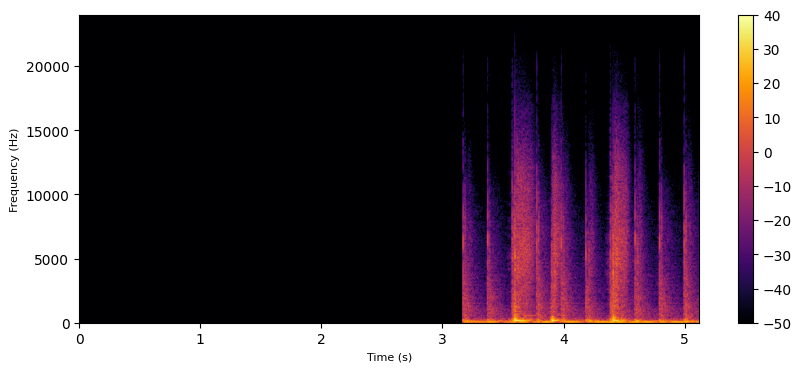

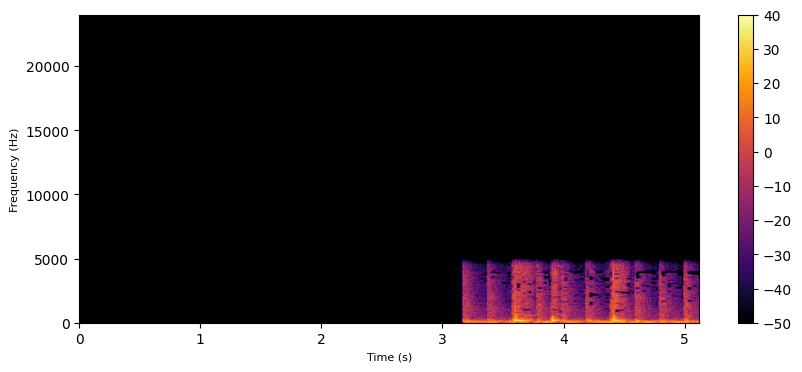

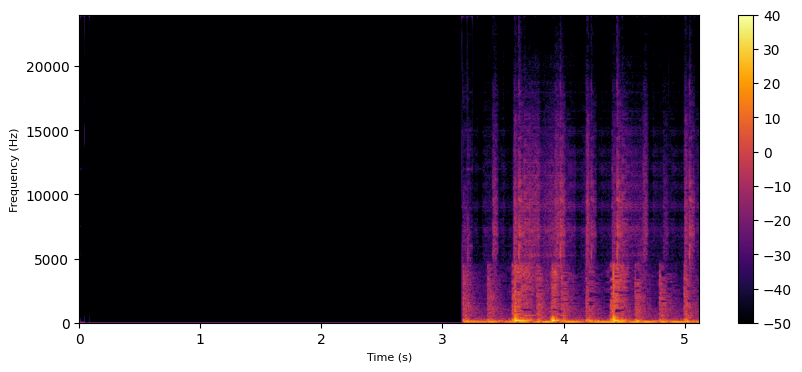

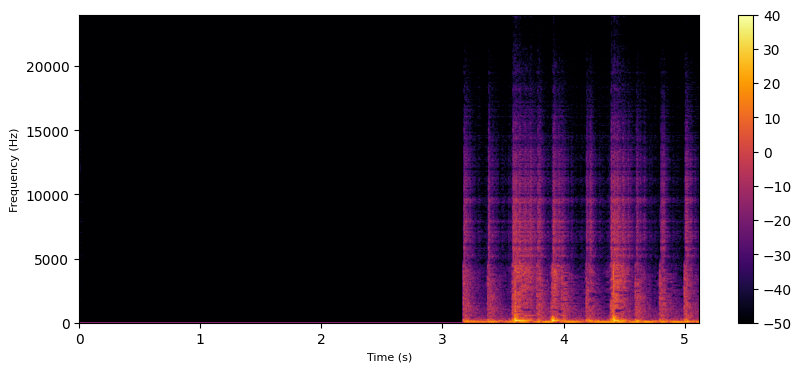

In [19]:
idx = torch.randint(1,250,size=(1,1))
print(idx)
# idx = 90
wb, nb, spec, name, label = dataset[idx]
wb, nb, spec, name, label = mus_dataset[idx]
print(name)
a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,4))
a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(wb, rate=48000))
display(Audio(nb, rate=48000))

with torch.no_grad():
    out = model(nb, spec)
    out2 = model2(nb, spec)

a = draw_spec(out.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(out.squeeze().numpy(), rate=48000))

a = draw_spec(out2.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(out2.squeeze().numpy(), rate=48000))